## Imagery layers and Raster analysis

In [1]:
import arcgis

### Access Landsat imagery

In [2]:
from arcgis.gis import GIS

In [3]:
gis = GIS(profile='agol_profile')

In [4]:
landsat_item = gis.content.search('title: Multispectral Landsat',
                                  'Imagery Layer', outside_org=True)[0]

In [5]:
landsat_item.layers

[<ImageryLayer url:"https://landsat2.arcgis.com/arcgis/rest/services/Landsat/MS/ImageServer">]

### View Landsat imagery layer item description

In [6]:
from IPython.display import HTML
HTML(landsat_item.description)

Band,Description,Wavelength (µm),Spatial Resolution (m)
1,Coastal aerosol,0.43 - 0.45,30
2,Blue,0.45 - 0.51,30
3,Green,0.53 - 0.59,30
4,Red,0.64 - 0.67,30
5,Near Infrared (NIR),0.85 - 0.88,30
6,SWIR 1,1.57 - 1.65,30
7,SWIR 2,2.11 - 2.29,30
8,Cirrus (in OLI this is band 9),1.36 - 1.38,30
9,QA Band (available with Collection 1)*,NA,30


### Access the layers available with the Landsat Imagery Layer item

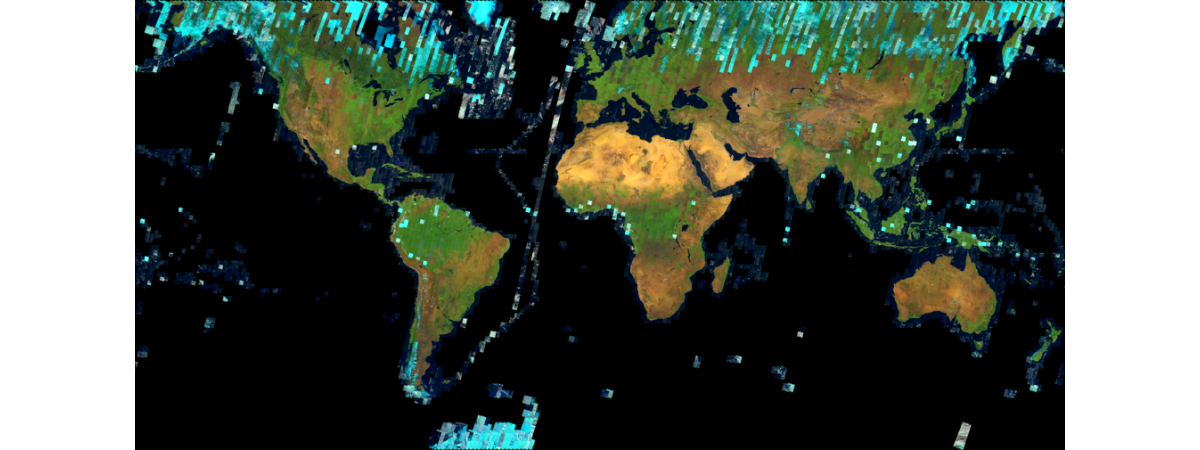

In [7]:
landsat = landsat_item.layers[0]
landsat 

## Explore different wavelength bands

In [8]:
import pandas as pd

In [9]:
pd.DataFrame(landsat.key_properties()['BandProperties'])

,BandName,WavelengthMax,WavelengthMin
0,CoastalAerosol,450.0,430.0
1,Blue,510.0,450.0
2,Green,590.0,530.0
3,Red,670.0,640.0
4,NearInfrared,880.0,850.0
5,ShortWaveInfrared_1,1650.0,1570.0
6,ShortWaveInfrared_2,2290.0,2110.0
7,Cirrus,1380.0,1360.0
8,NaN,NaN,NaN


## Visualize the layer in the map widget

In [10]:
m = gis.map('New York, NY')
m

MapView(layout=Layout(height='400px', width='100%'))

In [11]:
m.add_layer(landsat)

In [12]:
import time
from arcgis.raster.functions import apply

for idx, rasterfunc in enumerate(landsat.properties.rasterFunctionInfos):
    print (rasterfunc.name)
    m.add_layer(apply(landsat, rasterfunc.name))
    time.sleep(2)
    if idx > 4:
        break

Agriculture with DRA
Bathymetric with DRA
Color Infrared with DRA
Natural Color with DRA
Short-wave Infrared with DRA
Geology with DRA


### Interactive raster processing in Jupyter Notebook

In [13]:
color_infrared = apply(landsat, 'Color Infrared with DRA')

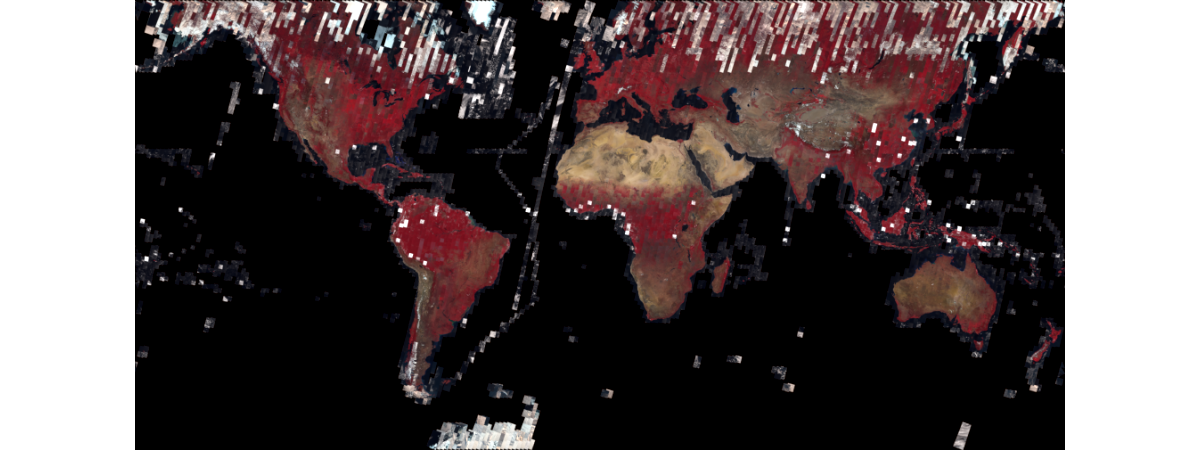

In [14]:
color_infrared 

In [15]:
m = gis.map('Phoenix, AZ')
m.add_layer(color_infrared)
m

MapView(layout=Layout(height='400px', width='100%'))

### Setting an area of interest

In [20]:
from arcgis.geocoding import geocode
area = geocode('Phoenix, AZ', out_sr=landsat.properties.spatialReference)[0]

In [21]:
color_infrared.extent = area['extent']

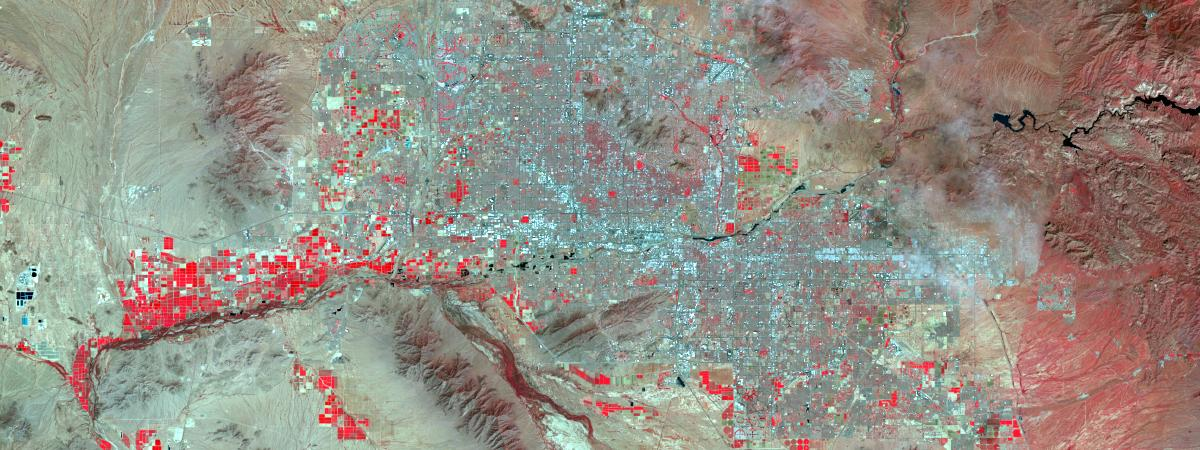

In [22]:
color_infrared

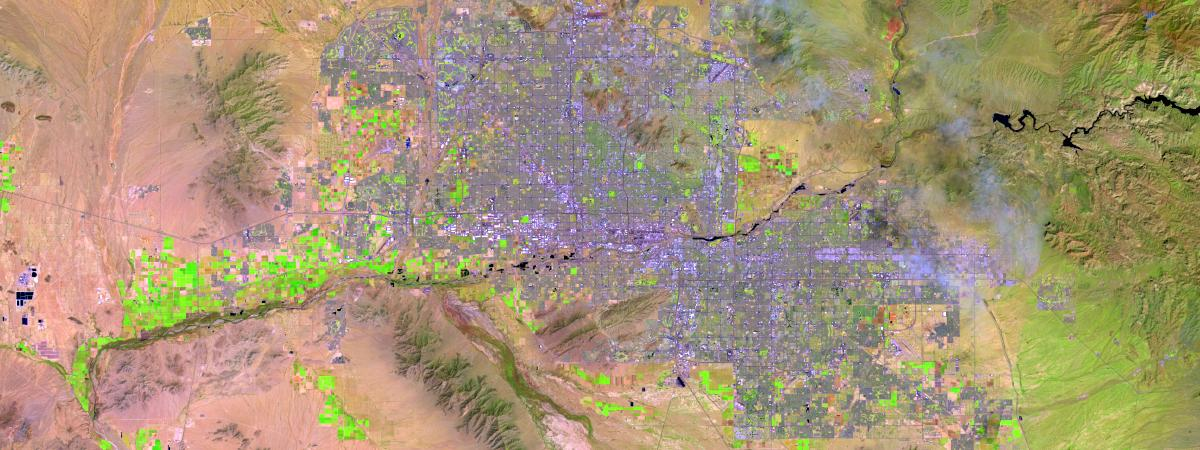

In [23]:
landsat.extent = area['extent']
landsat

## Exporting Images from Imagery Layer

In [24]:
from IPython.display import Image

### Exports an image to binary

In [25]:
img = landsat.export_image(bbox=area['extent'], size=[1200,450], f='image')

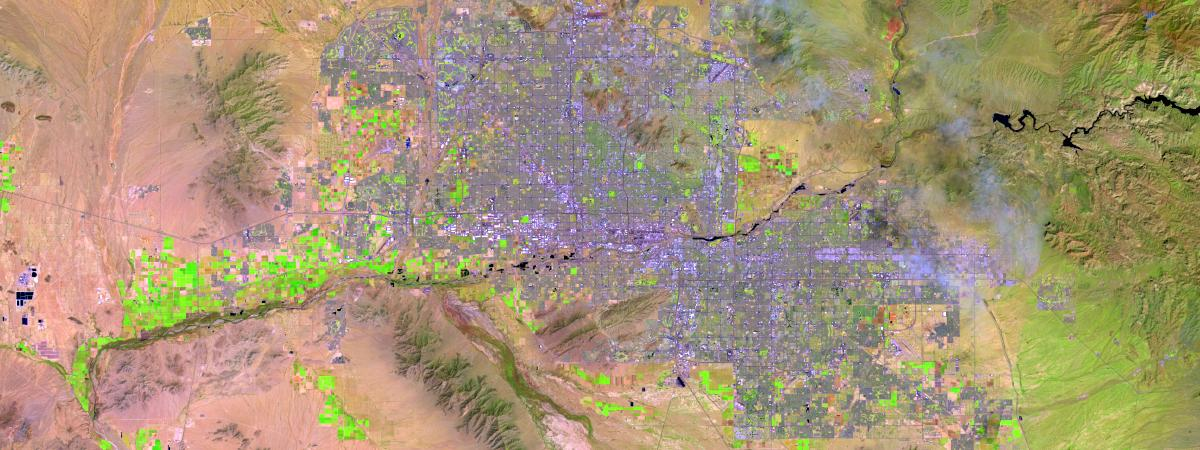

In [26]:
Image(img)

In [27]:
savedimg = landsat.export_image(bbox=area['extent'], size=[1200,450], 
                                f='image', save_folder='.', 
                                save_file='img.jpg')

In [28]:
savedimg

'.\\img.jpg'

In [31]:
from IPython.display import Image

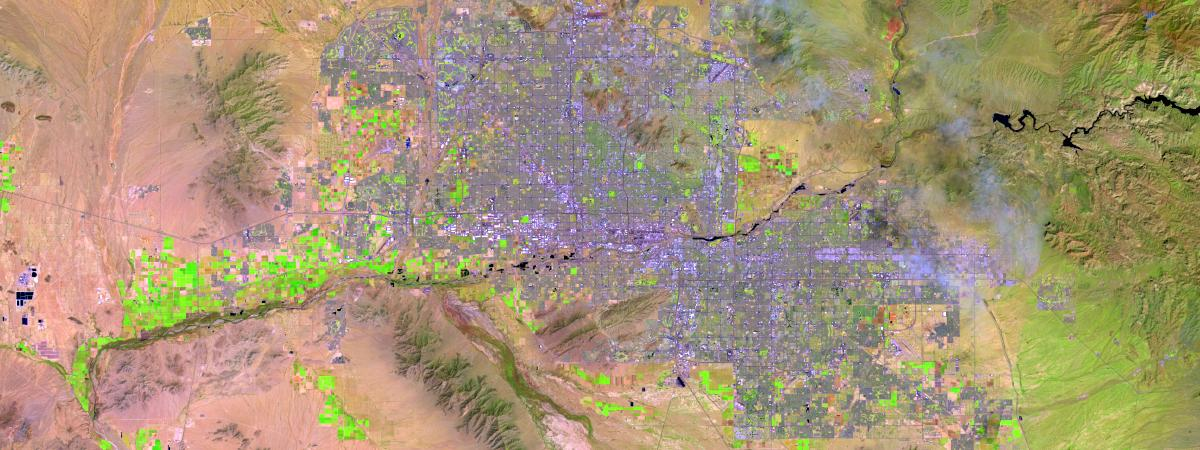

In [32]:
Image(filename=savedimg, width=1200, height=450)

### Exporting images with raster function applied to them

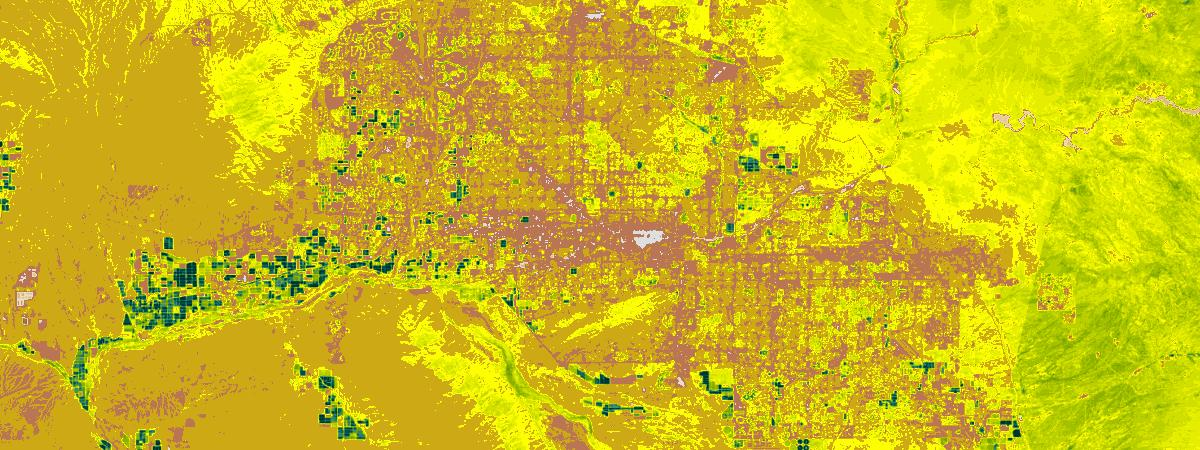

In [33]:
ndvi_colorized = apply(landsat, 'NDVI Colorized')
ndvi_colorized.extent = area['extent']
ndvi_colorized

## Extracting custom bands

In [34]:
from arcgis.raster.functions import stretch, extract_band

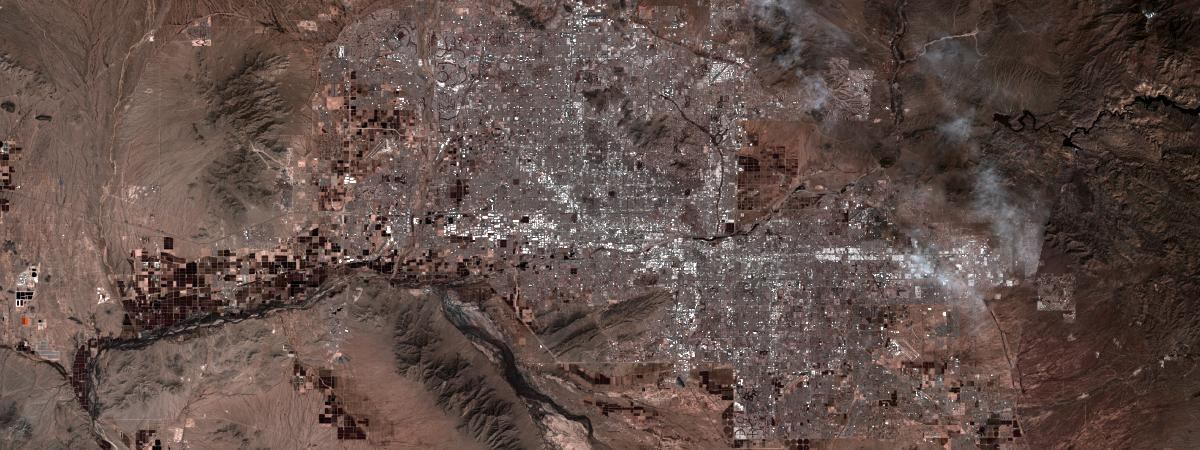

In [35]:
naturalcolor = stretch(extract_band(landsat, [3,2,1]), 
                    stretch_type='percentclip', min_percent=0.1, max_percent=0.1, 
                       gamma=[1, 1, 1], dra=True)
naturalcolor.extent = area['extent']
naturalcolor

# Clipping to an area of interest

In [65]:
from arcgis.geometry import Geometry, buffer 
from arcgis.raster.functions import clip, apply
%config IPCompleter.greedy=True

In [37]:
poly = buffer(geometries=[Geometry(area['location'])],
              in_sr=102100, distances=6000, unit='esriMeters')[0]

In [64]:
from  arcgis.geoenrichment import Country
usa = Country.get('US')
redlands = usa.subgeographies.states['California'].zip5['92373']

In [41]:
redclip = clip(apply(landsat, 'NDVI Colorized'), redlands.geometry)

In [42]:
m = gis.map('Redlands, CA')

In [43]:
m 

MapView(layout=Layout(height='400px', width='100%'))

In [46]:
m.add_layer(apply(landsat, 'NDVI Colorized'))
m.add_layer(redclip)

## Select images by where clause, geometry and time range

In [47]:
import arcgis

<Item title:"Sentinel-2 Views" type:Imagery Layer owner:esri>
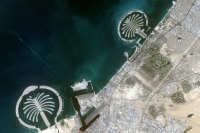

In [48]:
sentinel_item = gis.content.search('Sentinel-2 Views', outside_org=True)[0]
sentinel_item

In [51]:
sentinel = sentinel_item.layers[0]
sentinel.extent = area['extent']

In [54]:
selected = sentinel.filter_by(where="cloudcover <= .01 and category = 1",
                              geometry=arcgis.geometry.filters.intersects(area['extent']))

df = selected.query(out_fields="AcquisitionDate, Tile_ID, CloudCover", order_by_fields="AcquisitionDate").df
df['acquisitiondate'] = pd.to_datetime(df['acquisitiondate'], unit='ms')
df.tail()

,acquisitiondate,cloudcover,objectid,shape_Area,shape_Length,tile_id,SHAPE
318,2019-04-10 18:23:22,0.0000,6199453,1.138267e+09,220780.110030,20190410T182321_12SUC_0,"{'rings': [[[-12464677.8651, 3941828.561599999..."
319,2019-04-10 18:26:47,0.0038,6199486,1.702103e+10,521864.120441,20190410T182646_12SVB_0,"{'rings': [[[-12345205.114, 3822705.421400003]..."
320,2019-04-13 18:26:41,0.0000,6234754,1.700968e+10,521690.068069,20190413T182640_12SUB_0,"{'rings': [[[-12463589.3478, 3822225.777800001..."
321,2019-04-13 18:27:11,0.0001,6234767,7.143270e+09,374993.435297,20190413T182710_12SVB_0,"{'rings': [[[-12437387.706500001, 3822435.2823..."
322,2019-04-13 18:35:27,0.0017,6234871,1.736452e+10,527103.716430,20190413T183526_12SUC_0,"{'rings': [[[-12464677.8644, 3941827.167499996..."


Looking at the shape of the dataframe we see that multiple scenes match the specified criteria:

In [55]:
df.shape

(323, 7)

The footprints of the rasters matching the criteria can be drawn using the map widget:

In [56]:
df['Time'] = pd.to_datetime(df['acquisitiondate'], unit='ms')
df['Time'].tail(10)

313   2019-04-08 18:25:12
314   2019-04-08 18:25:58
315   2019-04-08 18:33:41
316   2019-04-08 18:34:12
317   2019-04-10 18:20:34
318   2019-04-10 18:23:22
319   2019-04-10 18:26:47
320   2019-04-13 18:26:41
321   2019-04-13 18:27:11
322   2019-04-13 18:35:27
Name: Time, dtype: datetime64[ns]

# Change Detection

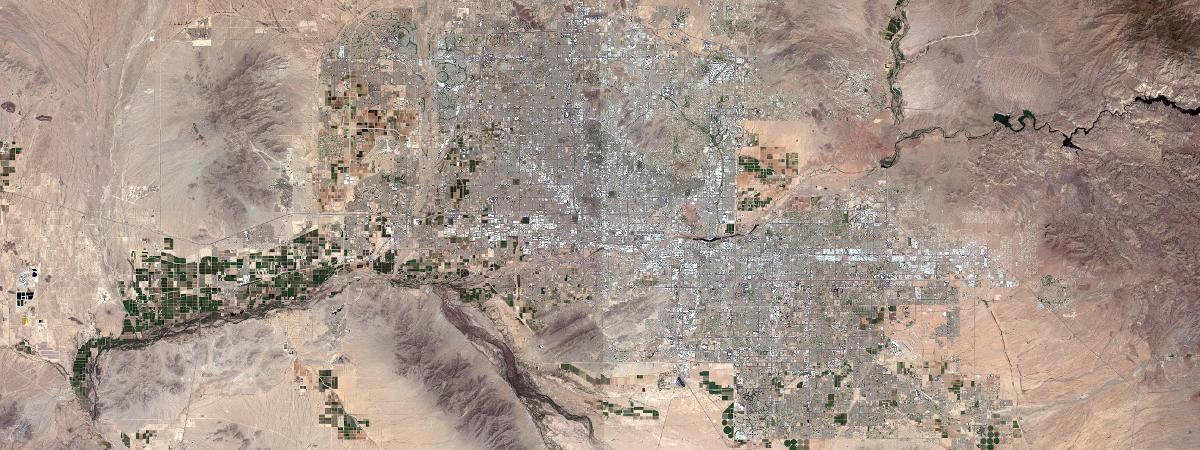

In [58]:
new = selected.last()
new

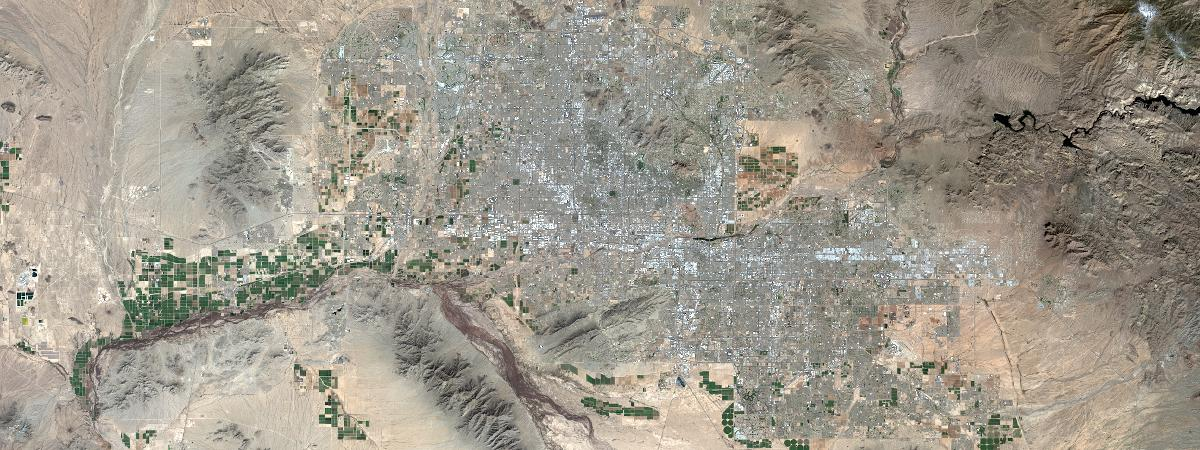

In [59]:
old = selected.first()
old

## Difference Image

Difference Image mode illustrates all the changes in NDVI (vegeration index) between the two dates:

increases are shown in green, and decreases are shown in magenta. 

In [60]:
from arcgis.raster.functions import *

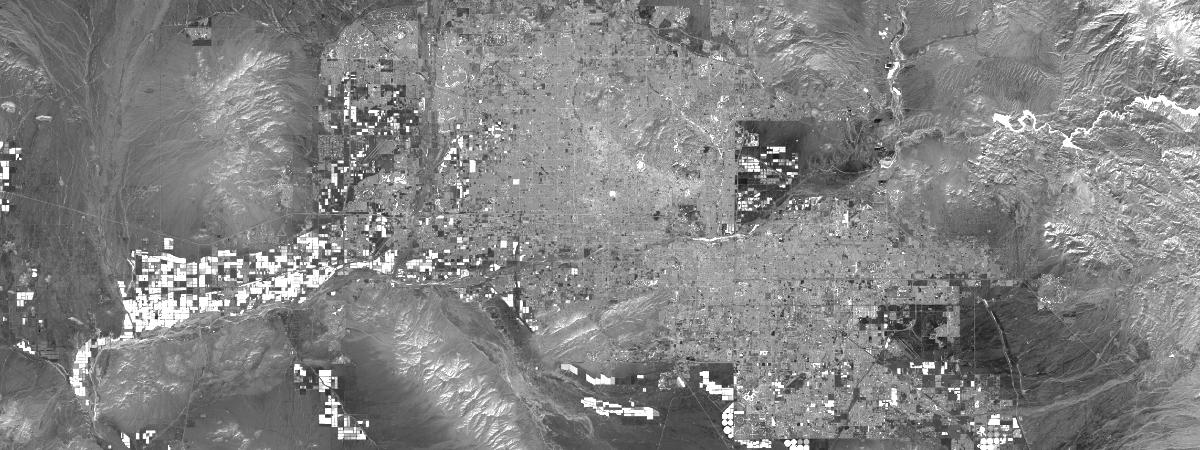

In [61]:
diff = stretch(composite_band([ndvi(old, '3 4'),
                               ndvi(new, '3 4')]), 
                               stretch_type='stddev',  num_stddev=3, min=0, 
                               max=255, dra=True, astype='u8')
diff

### Persisting your analysis for visualizaion or analysis

```python
lyr = diff.save('Test_viz_layer3')
```